In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Module 3.2 : Run CCDC over a tiled grid

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/3.2-CCDC_and_Scaling_Over_Large_Areas.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/3.2-CCDC_and_Scaling_Over_Large_Areas.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/3.2-CCDC_and_Scaling_Over_Large_Areas.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

## Overview


This notebook uses Landsat in the Continuous Change Detection and Classification (CCDC) temporal segmentation algorithm over a tiled grid in order to minimize memory errors

GEE can run out of memory for processes that use a deep stack of data, such as CCDC. Breaking exports into tiles can help avoid memory errors.

Learn more about CCDC:
- [CCDC Publication](https://www.sciencedirect.com/science/article/abs/pii/S0034425714000248).
- [GEE CCDC Documentation](https://developers.google.com/earth-engine/apidocs/ee-algorithms-temporalsegmentation-ccdc)

### Objective

In this tutorial, you learn how to create and manipulate CCDC outputs.

This tutorial uses the following Google Cloud services:

- `Google Earth Engine`

The steps performed include:



**The steps performed include:**

- Create tile mesh grid over a study area
- Create CCDC outputs over the mesh grid
- Manipulate EE array image objects to get meaningful data out of CCDC outputs - change detection

**Learning objectives include:**
- Users will understand the purpose of temporal segmentation as implemented in CCDC.
- Users will understand key parameters in CCDC algorithm. 
- Users will be able to generate and manipulate array outputs from CCDC. 


# Before you begin

### Set your current URL under `workbench_url`
This gives the Map Viewer a url in which to host the viewer we will be generating. 
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/` (See the image below)

![workspace url](img/workspace-url.png)

### Set a folder to use for all exports under `export_path_root` 
* This folder should be an assets folder in an existing GEE project.
* By default, this folder is the same as the pre-baked folder (where outputs have already been created). 
* If you would like to create your own outputs, specify a different path for `export_path_root`, but leave the `pre_baked_path_root` as it was. This way, the pre-baked outputs can be shown at the end, instead of waiting for all exports to finish.
* It will be something like `projects/projectID/assets/someFolder`
* This folder does not have to already exist. If it does not exist, it will be created

In [1]:
workbench_url = 'https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com'
pre_baked_path_root = 'projects/rcr-gee/assets/lcms-training'
export_path_root  = pre_baked_path_root

print('Done')

Done


# Installation
First, install necessary Python packages. Uncomment the first line to upgrade geeViz if necessary.

Note that for this module, we're also importing the `geeViz.changeDetectionLib as changeDetectionLib`. We will use this library later to 

In [3]:
#Module imports
#!python -m pip install geeViz --upgrade
try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml
import geeViz.gee2Pandas as g2p
import inspect

ee = getImagesLib.ee
Map = getImagesLib.Map

print('Done')

Done


## Set up your work environment

Create a folder in your export path where you will export the composites. In addition, create a blank image collection where your composites will live.

Currently, when running within Colab or Workbench, geeView uses a different project to authenticate through, so you may need to make your asset public to view from within Colab.

In [4]:
# Create folder and a collection and make public

export_ccdc_collection = f'{export_path_root}/lcms-training_module-3_CCDC'
aml.create_asset(export_ccdc_collection,asset_type = ee.data.ASSET_TYPE_IMAGE_COLL)

# Currently geeView within Colab uses a different project to authenticate through, so you may need to make your asset public to view from within Colab
aml.updateACL(export_ccdc_collection,writers = [],all_users_can_read = True,readers = [])


print('Done')

Found the following sub directories:  ['lcms-training', 'lcms-training_module-3_CCDC']
Will attempt to create them if they do not exist
Asset projects/rcr-gee/assets/lcms-training already exists
Asset projects/rcr-gee/assets/lcms-training/lcms-training_module-3_CCDC already exists
Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-3_CCDC
Done


In [6]:
# set up map
Map.clearMap()

# reset port if necessary
Map.port = 1235
Map.proxy_url = workbench_url

print('Done')

Done


## View tiles used in current CONUS LCMS workflow

Currently, we run LCMS for the Continental US (CONUS), Coastal Alaska, Hawaii, and Puerto Rico / the US Virgin Islands. 

For CONUS, we have to divide all processing up in order to avoid running out of memory.

This next block of code will show the tiles that our composites use for exporting to asset


In [11]:
# First, we'll view the tiles used in the current CONUS LCMS workflow
lcms_CONUS_composites = ee.ImageCollection('projects/lcms-tcc-shared/assets/Composites/Composite-Collection-yesL7-1984-2020')\
                                                .filter(ee.Filter.calendarRange(2022,2022,'year'))

# Pull the geometry of each tile in the composites
lcms_composites_tile_geo = lcms_CONUS_composites.map(lambda f:ee.Feature(f.geometry()).copyProperties(f,['studyAreaName']))

# Add the tiles and a composite for reference
Map.addLayer(lcms_CONUS_composites.mosaic(),getImagesLib.vizParamsTrue10k,'Example CONUS 2022 LCMS Composite')
Map.addLayer(lcms_composites_tile_geo,{},'LCMS Composite Tile Geometry')

Map.centerObject(lcms_composites_tile_geo)
Map.turnOnInspector()
Map.view()

Adding layer: Example CONUS 2022 LCMS Composite
Adding layer: LCMS Composite Tile Geometry
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com/proxy/1235/geeView/?accessToken=None


### When to use tiles 
* Note that these tiles are much larger than the entire area of our Puerto Rico and US Virgin Islands study area
* We generally only use tiles when a process fails due to memory or internal errors
* Then we divide the study area up into as large of a tile grid that will allow exports to complete

## Create tiles of various sizes

Here is an example of how to create a pyramid of tiles at various scales.
Below, a function will generate a grid of a set size in the projection being used 

## To determine what size tile you would use:
* Generally you would start with the biggest tile possible and work your way down till you stop having memory issues
* Currently, LCMS uses 480km tiles (with a 900m buffer) for most processing (everything but CCDC)

In [12]:
Map.clearMap()

# set study area and projection
lcms_CONUS_studyArea = ee.FeatureCollection('projects/lcms-292214/assets/CONUS-Ancillary-Data/conus')
lcms_CONUS_projection = lcms_CONUS_composites.first().projection()

def getGrid(studyArea,projection,size):
  grid = studyArea.geometry().coveringGrid(projection.atScale(size))
  Map.addLayer(grid,{},'Tile Grid {}m'.format(size))
  return grid

grid480= getGrid(lcms_CONUS_studyArea,lcms_CONUS_projection,480000)
getGrid(lcms_CONUS_studyArea,lcms_CONUS_projection,240000)
getGrid(lcms_CONUS_studyArea,lcms_CONUS_projection,120000)
getGrid(lcms_CONUS_studyArea,lcms_CONUS_projection,60000)
Map.addLayer(lcms_CONUS_studyArea,{},'LCMS CONUS Study Area')

Map.turnOnInspector()
Map.view()


Adding layer: Tile Grid 480000m
Adding layer: Tile Grid 240000m
Adding layer: Tile Grid 120000m
Adding layer: Tile Grid 60000m
Adding layer: LCMS CONUS Study Area
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com/proxy/1235/geeView/?accessToken=None


### Takeaway from this map
We can scale in all different sizes, but generally pyramid the tiles by dividing the size by 2 for each smaller size
Tiles might be too large or too small for area of interest depending on the size of the area and the complexity of the process being performed.

## Using Tiles
As an example of how to use this approach, we first need to get each available tile into a list
Then we would iterate across each tile, clip it to the study area, buffer it, get the data, and export, etc...

Zoom to the northwestern US to see these tiles

In [14]:
Map.clearMap()

ids = grid480.limit(2).aggregate_histogram('system:index').keys().getInfo()
for id in ids:
  # Get the tile and clip it to the study area and then buffer
  tile = grid480.filter(ee.Filter.eq('system:index',id)).geometry().intersection(lcms_CONUS_studyArea,240,lcms_CONUS_projection).buffer(900)
  Map.addLayer(tile,{},'Tile {}'.format(id))

Map.centerObject(tile)
Map.view()

Adding layer: Tile -3,-6
Adding layer: Tile -4,-6
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com/proxy/1235/geeView/?accessToken=None


## Example CCDC run

### Memory considerations
Since CCDC is the most memory intensive algorithm we use, you are the most likely to need to use this approach when running CCDC

If you run it from 1984 to 2023, even using just Landsat (rather than Landsat and Sentinel-2), you are much more likely to run out of memory

### Set up tiles for example

We'll use the full Puerto Rico and US Virgin Islands LCMS study area, and will run our analysis from 1984-2023.

In [11]:
# clear the map
Map.clearMap()

# Set the size (in meters) of the tiles
tileSize = 60000

# Specify study area
studyArea = ee.FeatureCollection('projects/lcms-292214/assets/R8/PR_USVI/Ancillary/prusvi_boundary')


# Set the projection
crs = getImagesLib.common_projections['NLCD_CONUS']['crs']
transform  = getImagesLib.common_projections['NLCD_CONUS']['transform']
scale = None
projection = ee.Projection(crs,transform)


# Get the grid
grid = studyArea.geometry().coveringGrid(projection.atScale(tileSize))
Map.addLayer(grid,{},'Tile Grid {}m'.format(tileSize))


Map.addLayer(studyArea,{},'Study Area')
Map.turnOnInspector()
Map.centerObject(studyArea)
Map.view()

Adding layer: Tile Grid 60000m
Adding layer: Study Area
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com/proxy/1235/geeView/?accessToken=None


### Define parameters for Landsat imagery 

First let's set up some Landsat and CCDC parameters.

We'll use the full Puerto Rico and US Virgin Islands LCMS study area, and will run our analysis from 1984-2023.

The parameters below you should seem familiar from module 2

In [8]:
# We'll use the full Puerto Rico and US Virgin Islands LCMS study area
studyArea = ee.FeatureCollection('projects/lcms-292214/assets/R8/PR_USVI/Ancillary/prusvi_boundary')

#Specify start and end years for all analyses
#More than a 3 year span should be provided for time series methods to work
#well. If providing pre-computed stats for cloudScore and TDOM, this does not
#matter
startYear = 1984
endYear = 2023

#Update the startJulian and endJulian variables to indicate your seasonal
#constraints. This supports wrapping for tropics and southern hemisphere.
#If using wrapping and the majority of the days occur in the second year, the system:time_start will default
#to June 1 of that year.Otherwise, all system:time_starts will default to June 1 of the given year
#startJulian: Starting Julian date
#endJulian: Ending Julian date
startJulian = 1
endJulian = 365

#Choose whether to include Landat 7
#Generally only included when data are limited
includeSLCOffL7 = True

print('Done')

Done


### Set export parameters

#### Export bands
First, set Which bands/indices to export
These will not always be used to find breaks - that is specified below in the ccdcParams

Options are: ["blue","green","red","nir","swir1","swir2","NDVI","NBR","NDMI","NDSI","brightness","greenness","wetness","fourth","fifth","sixth","tcAngleBG"]

Be sure that any bands in `ccdcParams.breakpointBands` parameter, which we'll set next, are in this list

#### Export projection and scale


In [33]:
# set export bands
exportBands = ["blue","green","red","nir","swir1","swir2","NDVI"]


#### Visualization parameters

Adjusting settings for how the visualizer displays false color imagery

In [34]:
# set viz params
getImagesLib.vizParamsFalse['min']=0.15
getImagesLib.vizParamsFalse['max']=0.8

### Set CCDC parameters

* [GEE CCDC Documentation](https://developers.google.com/earth-engine/apidocs/ee-algorithms-temporalsegmentation-ccdc)


**CCDC Parameters include:**
| Argument             | Type                    | Details                                                                                                                                                                                                                                |
|----------------------|-------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| collection           | ImageCollection         | Collection of images on which to run CCDC.                                                                                                                                                                                             |
| breakpointBands      | List, default: None     | The name or index of the bands to use for change detection. If unspecified, all bands are used.                                                                                                                                        |
| tmaskBands           | List, default: None     | The name or index of the bands to use for iterative TMask cloud detection. These are typically the green band and the SWIR1 band. If unspecified, TMask is not used. If specified, 'tmaskBands' must be included in 'breakpointBands'. |
| minObservations      | Integer, default: 6     | The number of observations required to flag a change.                                                                                                                                                                                  |
| chiSquareProbability | Float, default: 0.99    | The chi-square probability threshold for change detection in the range of [0, 1]                                                                                                                                                       |
| minNumOfYearsScaler  | Float, default: 1.33    | Factors of minimum number of years to apply new fitting.                                                                                                                                                                               |
| dateFormat           | Integer, default: 0     | The time representation to use during fitting: 0 = jDays, 1 = fractional years, 2 = unix time in milliseconds. The start, end and break times for each temporal segment will be encoded this way.                                      |
| lambda               | Float, default: 20      | Lambda for LASSO regression fitting. If set to 0, regular OLS is used instead of LASSO. 20 would be if input data was scaled 0-10000. If 0-1 reflectance, 20 would become 0.002                                                                                                                                                |
| maxIterations        | Integer, default: 25000 | Maximum number of runs for LASSO regression convergence. If set to 0, regular OLS is used instead of LASSO.                                                                                                                            |
* Run the code chunk below to set the parameters that you'll use in the CCDC model.


In [35]:
ccdcParams ={
  'breakpointBands':['green','red','nir','swir1','swir2','NDVI'],
  'tmaskBands' : None,
  'minObservations': 6,
  'chiSquareProbability': 0.99,
  'minNumOfYearsScaler': 1.33,
  'lambda': 0.002,# Since our reflectance data is 0-1 and not 0-10000, we divide 20 by 10000
  'maxIterations' : 25000,
  'dateFormat' : 1
}

print('Done')

Done


#### Function to remove any extremely high band / index values

That might be artifacts and result in errors

In [36]:
# Write function to Remove any extremely high band/index values
def removeGT1(img):
  lte1 = img.select(['blue','green','nir','swir1','swir2']).lte(1).reduce(ee.Reducer.min());
  return img.updateMask(lte1);

### Iterate across a tile and run CCDC

* Now, we'll iterate across one tile and run CCDC as an example of how to use this approach to create composites. 
* Double-click on the outputs to see the values of the raw Landsat data and how they relate to the CCDC raw output. 
* You'll notice the raw CCDC output is even more complex than the LandTrendr output.

In [73]:
Map.clearMap()

# list ids
ids = grid.aggregate_histogram('system:index').keys().getInfo()


# Get the tile and buffer it so there are no missing pixels at tile edges
# We'll use the tile that falls over El Yunque National Forest
# Any smaller subset should work though
tile = grid.filter(ee.Filter.eq('system:index',ids[6]))

Map.addLayer(tile,{},'Tile {}'.format(id))
Map.centerObject(tile)
processedScenes = getImagesLib.getProcessedLandsatScenes(studyArea = tile,startYear = startYear, endYear = endYear,
                                                    startJulian = startJulian,endJulian = endJulian,
                                                    includeSLCOffL7 = includeSLCOffL7).select(exportBands)
processedScenes = processedScenes.map(removeGT1)
# print(processedScenes.size().getInfo())

#Set the scene collection in the ccdcParams
ccdcParams['collection'] = processedScenes

#Run CCDC
ccdc = ee.Image(ee.Algorithms.TemporalSegmentation.Ccdc(**ccdcParams))
Map.addLayer(processedScenes,{},'Raw Processed Landsat Input')
Map.addLayer(ccdc,{},'CCDC Output')



Map.turnOnInspector()
Map.view()

Adding layer: Tile 96,53
Get Processed Landsat: 
Start date: Jan 01 1984 , End date: Dec 31 2023
Applying scale factors for C2 L4 data
Applying scale factors for C2 L5 data
Applying scale factors for C2 L8 data
Including All Landsat 7
Applying scale factors for C2 L7 data
Applying scale factors for C2 L9 data
Applying Fmask Cloud Mask
Applying Fmask Shadow Mask
Adding layer: Raw Processed Landsat Input
Adding layer: CCDC Output
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com/proxy/1235/geeView/?accessToken=None


* In order to understand how CCDC outputs relate to the original input data, we will join the raw input NDVI values to the predicted NDVI values from CCDC
* Extracting the data can take some time. Please be patient.

Adding layer: Raw Landsat and CCDC Fitted
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com/proxy/1235/geeView/?accessToken=None


Extracting raw Landsat and fitted CCDC values
Done


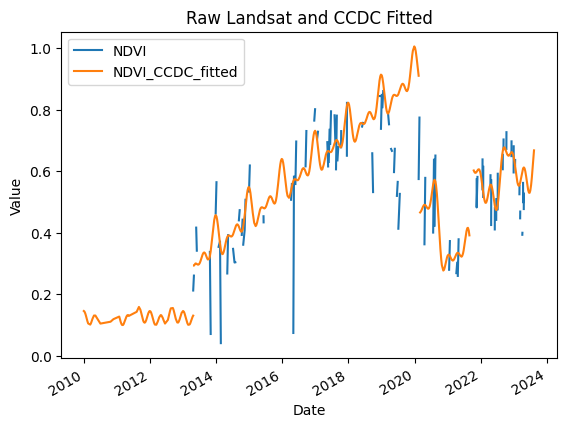

In [83]:
Map.clearMap()

# Specify which bands to show in the example
exampleBandNames = ['NDVI']

# Now let's join the raw and predicted CCDC for a small subset of time 
processedScenes = processedScenes\
                    .filter(ee.Filter.calendarRange(2010,2023,'year'))\
                    .map(getImagesLib.addYearYearFractionBand)
#Then predict the CCDC models
fitted = changeDetectionLib.predictCCDC(ccdc,processedScenes.select(['year']),fillGaps=False,whichHarmonics=[1,2,3])

exampleFittedBandNames = [f'{bn}_CCDC_fitted' for bn in exampleBandNames]

ccdcJoined = getImagesLib.joinCollections(processedScenes.select(exampleBandNames),fitted.select(exampleFittedBandNames))
ccdcJoinedBns = ccdcJoined.first().bandNames().getInfo()

# View the map
# Querying this map will often yield errors as this process is quite computationally intensive
Map.addLayer(ccdcJoined,{'min':0.2,'max':0.8},'Raw Landsat and CCDC Fitted')
Map.turnOnInspector()
Map.view()



* We'll extract a single pixel of the output to illustrate how the raw inputs relate to the fitted CCDC output

Extracting raw Landsat and fitted CCDC values
Done


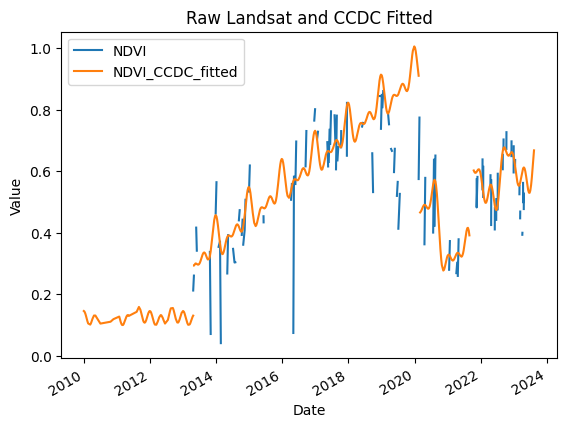

In [86]:
# # Provide an example location 
pt = ee.Geometry.Point([ -65.944 , 18.404])

# Extract the values and plot them
print('Extracting raw Landsat and fitted CCDC values')
timSeries = g2p.extractPointValuesToDataFrame(ccdcJoined,pt,scale=None,crs = crs, transform = transform)
timSeries['system:time_start']= g2p.pandas.to_datetime(timSeries['system:time_start'], unit='ms')

timSeriesT = timSeries[ccdcJoinedBns]
timSeriesT.index = timSeries['system:time_start']
timSeriesT.plot.line(title='Raw Landsat and CCDC Fitted',xlabel='Date',ylabel='Value')

print('Done')

### Iterate across all tiles and export CCDC outputs
* Now that we have reviewed how to run CCDC over Landsat data, we will do so over our processing tiles and export it as an asset


In [87]:
#iterate over ids
for id in ids:
    print(id)
    # Get the tile and buffer it so there are no missing pixels at tile edges
    tile = grid.filter(ee.Filter.eq('system:index',id)).geometry().intersection(studyArea,240,projection).buffer(900)
    
    # Map.addLayer(tile,{},'Tile {}'.format(id))
    
    processedScenes = getImagesLib.getProcessedLandsatScenes(studyArea = tile,startYear = startYear, endYear = endYear,
                                                        startJulian = startJulian,endJulian = endJulian,
                                                        includeSLCOffL7 = includeSLCOffL7).select(exportBands)
    processedScenes = processedScenes.map(removeGT1)
    # print(processedScenes.size().getInfo())
    
    #Set the scene collection in the ccdcParams
    ccdcParams['collection'] = processedScenes

    #Run CCDC
    ccdc = ee.Image(ee.Algorithms.TemporalSegmentation.Ccdc(**ccdcParams))
    ccdc = ccdc.set({'startYear':startYear,
                     'endYear':endYear,
                     'startJulian':startJulian,
                     'endJulian':endJulian,
                     'TileSize':tileSize,
                     'TileID':id})
    
    # Export the output
    exportName = 'CCDC_Tile-{}m_ID{}_yrs{}-{}_jds{}-{}'.format(tileSize,id.replace(',','-'),startYear,endYear,startJulian,endJulian)
    exportPath = f'{export_ccdc_collection}/{exportName}'
    print(exportPath)

    getImagesLib.exportToAssetWrapper(ccdc,exportName,exportPath,{'.default':'sample'},tile,scale,crs,transform,overwrite=False)
    
print('Done')

90,54
Get Processed Landsat: 
Start date: Jan 01 1984 , End date: Dec 31 2023
Applying scale factors for C2 L4 data
Applying scale factors for C2 L5 data
Applying scale factors for C2 L8 data
Including All Landsat 7
Applying scale factors for C2 L7 data
Applying scale factors for C2 L9 data
Applying Fmask Cloud Mask
Applying Fmask Shadow Mask
projects/rcr-gee/assets/lcms-training/lcms-training_module-3_CCDC/CCDC_Tile-60000m_ID90-54_yrs1984-2023_jds1-365
CCDC_Tile-60000m_ID90-54_yrs1984-2023_jds1-365 currently exists or is being exported and overwrite = False. Set overwite = True if you would like to overwite any existing asset or asset exporting task
91,52
Get Processed Landsat: 
Start date: Jan 01 1984 , End date: Dec 31 2023
Applying scale factors for C2 L4 data
Applying scale factors for C2 L5 data
Applying scale factors for C2 L8 data
Including All Landsat 7
Applying scale factors for C2 L7 data
Applying scale factors for C2 L9 data
Applying Fmask Cloud Mask
Applying Fmask Shadow M

### Task tracking

Can track tasks here or at https://code.earthengine.google.com/tasks
If you'd like to track the tasks, use the code below

In [67]:
# Can track tasks here or at https://code.earthengine.google.com/tasks
# If you'd like to track the tasks, use this:
# tml.trackTasks2()

# If you want to cancel all running tasks, you can use this function
# tml.batchCancel()

# If you want to empty the collection of all images
# aml.batchDelete(exportPathRoot, type = 'imageCollection')

print('done')

done


### Inspect outputs - whole map 

Bring in the outputs and mosaic them into a single image. We will use this image later. 



In [88]:
Map.clearMap()

# Bring in the outputs and mosaic them into a single image
ccdcImg = ee.ImageCollection(f'{pre_baked_path_root}/lcms-training_module-3_CCDC').mosaic()
Map.addLayer(ccdcImg,{'addToLegend':False},'CCDC Raw Image')
Map.centerObject(studyArea,10)
Map.turnOnInspector()
Map.view()

Adding layer: CCDC Raw Image
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com/proxy/1235/geeView/?accessToken=None


### Use CCDC to detect change

We will need to manipulate the array image to get meaningful data such as synthetic composites and harmonic coefficients

CCDC has a fundamentally different definition of what "change" is from LandTrendr. LandTrendr defines change as a change in the linear direction of the time series as depicted with a linear regression model, while CCDC defines change as a change in the seasonlity (phenology) as depicted using harmonic regression (linear regression over many different wave forms). 

As a result, in general, LandTrendr's depiction of change aligns with many forest-related change types such as fire, insects and disease, etc. While these types of changes often change the direction of the trajectory abruptly, they do not always change the seasonlity patterns in an abrupt manner. 

CCDC can be better at detection detecting changes that merely impact the phenology that LandTrendr can miss though. This can be useful in agricultural and rangeland applications.

Below, we'll inspect the `ccdcChangeDetection` function in the `changeDetectionLib` to see what kind of parameters and inputs we'll need. 

In [89]:
# print option
print(inspect.getsource(changeDetectionLib.ccdcChangeDetection))

def ccdcChangeDetection(ccdcImg,bandName):
  magKeys = ['.*_magnitude']
  tBreakKeys = ['tBreak']
  changeProbKeys = ['changeProb']
  changeProbThresh = 1

  #Pull out pieces from CCDC output
  magnitudes = ccdcImg.select(magKeys)
  breaks = ccdcImg.select(tBreakKeys)
  
  #Map.addLayer(breaks.arrayLength(0),{'min':1,'max':10});
  changeProbs = ccdcImg.select(changeProbKeys)
  changeMask = changeProbs.gte(changeProbThresh)
  magnitudes = magnitudes.select(bandName + '.*')

  
  #Sort by magnitude and years
  breaksSortedByMag = breaks.arraySort(magnitudes)
  magnitudesSortedByMag = magnitudes.arraySort()
  changeMaskSortedByMag = changeMask.arraySort(magnitudes)
  
  breaksSortedByYear = breaks.arraySort()
  magnitudesSortedByYear = magnitudes.arraySort(breaks)
  changeMaskSortedByYear = changeMask.arraySort(breaks)
  
  #Get the loss and gain years and magnitudes for each sorting method
  highestMagLossYear = breaksSortedByMag.arraySlice(0,0,1).arrayFlatten([['loss_year']])
  highestM

#### Takeaways from the ccdcChangeDetection function
Some notes and highlights with things to pay attention to in the function

### Set change detection parameters for CCDC algorithm
This function allows us to manipulate CCDC outputs in array format in order to get meaningful information -- that is, information that's more directly useful than a modeled spectral trajectory. 

#### Specify which band to use for loss and gain.

This is most important for the loss and gain magnitude since the year of change will be the same for all years
`changeDetectionBandName = 'NDVI'`

Choose whether to show the most recent (`'mostRecent'`) or highest magnitude (`'highestMag'`) CCDC break
`sortingMethod = 'mostRecent'`

In [90]:
#Specify which band to use for loss and gain.
#This is most important for the loss and gain magnitude since the year of change will be the same for all years
changeDetectionBandName = 'NDVI'

# Choose whether to show the most recent ('mostRecent') or highest magnitude ('highestMag') CCDC break
sortingMethod = 'mostRecent'

### Run CCDC change detection and inspect outputs

We will not look at more useful ways of visualizing CCDC outputs
First, we will extract the change years and magnitude

Double click on map to see raw years of loss and gain breaks
Notice as you zoom in the layers change since GEE is processing outputs at a given pyramid level

In [91]:
#We will not look at more useful ways of visualizing CCDC outputs
#First, we will extract the change years and magnitude
changeObj = changeDetectionLib.ccdcChangeDetection(ccdcImg,changeDetectionBandName);

# clear map
Map.clearMap()

# add new layers to map
Map.addLayer(changeObj[sortingMethod]['loss']['year'],{'min':startYear,'max':endYear,'palette':changeDetectionLib.lossYearPalette},'Loss Year')
Map.addLayer(changeObj[sortingMethod]['loss']['mag'],{'min':-0.5,'max':-0.1,'palette':changeDetectionLib.lossMagPalette},'Loss Mag',False);
Map.addLayer(changeObj[sortingMethod]['gain']['year'],{'min':startYear,'max':endYear,'palette':changeDetectionLib.gainYearPalette},'Gain Year');
Map.addLayer(changeObj[sortingMethod]['gain']['mag'],{'min':0.05,'max':0.2,'palette':changeDetectionLib.gainMagPalette},'Gain Mag',False);

Map.centerObject(studyArea,10)
Map.turnOnInspector()
Map.view()


Adding layer: Loss Year
Adding layer: Loss Mag
Adding layer: Gain Year
Adding layer: Gain Mag
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1235/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com/proxy/1235/geeView/?accessToken=None




We will need to manipulate the array image to get meaningful data such as synthetic composites and harmonic coefficients
This function is useful to get the **harmonic model coefficient values** for a given date image 
`changeDetectionLib.getCCDCSegCoeffs`

In [92]:
# We will need to manipulate the array image to get meaningful data such as synthetic composites and harmonic coefficients
# This function is useful to get the harmonic model coefficient values for a given date image 
print(inspect.getsource(changeDetectionLib.getCCDCSegCoeffs) )
Map.clearMap()

fillGaps = False
segCoeffs = changeDetectionLib.getCCDCSegCoeffs(ee.Image(2015.5), ccdcImg, fillGaps)
Map.addLayer(segCoeffs, {}, 'Seg Coeffs')
Map.addLayer(ccdcImg, {}, 'Raw Img')

Map.turnOnInspector()
Map.view()




def getCCDCSegCoeffs(timeImg,ccdcImg,fillGaps):
  coeffKeys = ['.*_coefs']
  tStartKeys = ['tStart']
  tEndKeys = ['tEnd']
  tBreakKeys = ['tBreak']
  
  #Get coeffs and find how many bands have coeffs
  coeffs = ccdcImg.select(coeffKeys)
  bns = coeffs.bandNames()
  nBns = bns.length()
  harmonicTag = ee.List(['INTP','SLP','COS1','SIN1','COS2','SIN2','COS3','SIN3'])

   
  #Get coeffs, start and end times
  coeffs = coeffs.toArray(2)
  tStarts = ccdcImg.select(tStartKeys)
  tEnds = ccdcImg.select(tEndKeys)
  tBreaks = ccdcImg.select(tBreakKeys)
  
  #If filling to the tBreak, use this
  tStarts = ee.Image(ee.Algorithms.If(fillGaps,tStarts.arraySlice(0,0,1).arrayCat(tBreaks.arraySlice(0,0,-1),0),tStarts))
  tEnds = ee.Image(ee.Algorithms.If(fillGaps,tBreaks.arraySlice(0,0,-1).arrayCat(tEnds.arraySlice(0,-1,None),0),tEnds))
  
  
  #Set up a mask for segments that the time band intersects
  tMask = tStarts.lt(timeImg).And(tEnds.gte(timeImg)).arrayRepeat(1,1).arrayRepeat(2,1)
  coeffs = 

In [121]:

# Provide an example location 
pt = ee.Geometry.Point([ -65.944 , 18.404])

 

coeffKeys = ['.*_coefs']
tStartKeys = ['tStart']
tEndKeys = ['tEnd']
tBreakKeys = ['tBreak']

#Get coeffs and find how many bands have coeffs
coeffs = ccdcImg.select(coeffKeys)
bns = coeffs.bandNames().getInfo()
input_bns = [bn.split('_')[0] for bn in bns]
harmonicTag = ['INTP','SLP','COS1','SIN1','COS2','SIN2','COS3','SIN3']


#Get coeffs, start and end times
coeffs = coeffs.toArray(2)
tStarts = ccdcImg.select(tStartKeys)
tEnds = ccdcImg.select(tEndKeys)
tBreaks = ccdcImg.select(tBreakKeys)

index = [f'Segment {i}' for i in list(range(1,6))]

print('Each pixel has any number of segments. For each segment, there is a model for each band.')
print('E.g. The intercepts for the first segment are:')
display(g2p.imageArrayPixelToDataFrame(coeffs.arraySlice(1,0,1).arraySlice(0,0,1).arrayProject([2,1]), pt,None,crs,transform, 'Intercept',columns =input_bns ))

print('Looking at all coefficients for a given pixel for all bands and all segments, it looks like this:')

display(g2p.imageArrayPixelToDataFrame(coeffs, pt,None,crs,transform, 'Coeffs',columns = harmonicTag,index=index))


Each pixel has any number of segments. For each segment, there is a model for each band.
E.g. The intercepts for the first segment are:


,blue,green,red,nir,swir1,swir2,NDVI
0,2.883502,3.282841,1.889072,19.140961,5.329586,1.267390,0.760559


Looking at all coefficients for a given pixel for all bands and all segments, it looks like this:


,INTP,SLP,COS1,SIN1,COS2,SIN2,COS3,SIN3
Segment 1,"[2.8835019637837616, 3.2828407883810056, 1.8890716245408166, 19.14096117316336, 5.32958581685124, 1.2673900698228309, 0.7605586342114968]","[-0.0014289784894894713, -0.0016160401283955837, -0.000923589550535398, -0.009436630923169133, -0.0025919058730427776, -0.0006002759631661662, 0]","[-0.01186843936476042, -0.02098628819978426, -0.01571539305900891, -0.056630206538701544, -0.020291496499357173, -0.008427349310669975, 0.04611739888770422]","[0, 0, 0, -0.004567996992550899, 0.003230075007047745, 0, 0.009124222149743245]","[0, -0.0016317531211471504, -0.001774852987395223, -0.005093326960209953, -0.02064884629845176, -0.011918990964258388, 0.00213493267705074]","[0, 0, 0, 0, 0, 0, 0.01964705696807787]","[0.002384153070020832, 0.003457602225186136, 0.0025340059036947633, 0, 0, 0.0009508011613858051, -0.025616353056236732]","[0.002910448220751587, 0.005529002494703668, 0.004594814712743522, 0.00042706699447165783, 0.009437693570915878, 0.0030991824168144955, -0.03118448910164181]"
Segment 2,"[-8.178675304391675, -8.567455788409305, -8.585631842168647, -10.887516806370494, 0.42282078696136705, 0.28414772604338856, 0.1243622199456729]","[0.004146312252314901, 0.004394562620758038, 0.004441637236630287, 0.00563385399970798, 0, 0, 0]","[-0.015031742753393139, -0.018733700849538595, -0.015736692525579243, -0.017957310568418212, -0.013183662346069571, -0.014953523384902585, 0]","[0.01045798256411022, 0.018567807032632097, 0.021002172225181297, 0.015381522615022576, 0.04884627085686614, 0.05317092519847767, -0.009940719367876655]","[-9.026335174490329e-05, 0, 0, 0, -0.011864347346887232, -0.008475299950807794, 0]","[0.0001973748731300362, 0.00020375191168091125, 0, 0.007281413879694335, 0.033224318510948876, 0.03621641435912726, 0.005348317025927302]","[-0.010136155719827131, -0.017678294046348877, -0.023494124785338872, -0.010202604645432222, -0.028253406666658296, -0.03274715185488118, 0.020911638035406462]","[0.007635588989686705, 0.008221749753545272, 0.007934732692333683, 0.011885234801459157, 0, 0, 0]"
Segment 3,"[40.921006545882534, 50.895096297031586, 69.48867809045338, 0.8834294022409347, 76.92873468727524, 59.97626481008383, -183.77273951155982]","[-0.020259890824980097, -0.02518305107288108, -0.03440506306050126, -0.00023969860291634586, -0.03800332636106635, -0.02966235885704887, 0.09142888258873613]","[0, 0, -0.0024225947032943487, -0.0016084047433077091, -0.016494180170297905, -0.013406892788657997, 0.02902326656997849]","[0.005854176136300245, 0.00397697856325619, 0.007443825668502859, -0.0076462463157694425, 0.0021441131566921037, 0.002351250810332423, -0.012174527610339603]","[-0.014370010048930525, -0.013268489602268415, -0.01680896003632936, -0.0036527915819201755, -0.019796965920781923, -0.013964558531023071, 0.03579450237639679]","[0.008811111586499342, 0.012618469843064676, 0.01361870695976215, 0.024766213847678697, 0.021772726540925325, 0.014124435464744166, -0.0065829842625007]","[-0.020052238813802078, -0.015932060670294356, -0.01707310212186034, 0, -0.004396921947604966, -0.0042026664281565864, 0.026255827857797617]","[0, 5.383251312164806e-06, 0, 0, 0, 0, -0.005891841365245101]"
Segment 4,"[-81.05418526482875, -118.01267002729952, -158.2880580670942, -30.30693193427896, -196.03929233869582, -162.25359177311236, 315.4606911372531]","[0.040157854624715446, 0.058484343822889764, 0.07842674538386808, 0.015224468791355944, 0.09720045762482044, 0.08041071502669586, -0.15590816344669936]","[0.007472415860416005, 0.014965945315045614, 0.028236782931977088, 0, 0.0456677755800225, 0.04424488962356279, -0.08085708479463748]","[0.0005224995743545358, 0, 0.0019928640089984374, -0.0047594782098874374, 0, 0, -0.005990266176790861]","[-0.007480593138068563, -0.014385875825021191, -0.019532340820599563, -0.02110208150576144, -0.05293998042020171, -0.037081218150552306, 0.00983054564983115]","[-0.0047991985520175195, -0.008273657115843325, -0.013458547981285734, 0.009891817020

* One of the most common uses of CCDC is to find the which model a specified date intersects, and get the predicted values from the model as well as the coefficients from the model itself
* In order to do this, the first step is to find which segment a specified date falls within
* We will now look at the structure of the date information for each segment

In [13]:
print('The tStarts are the start and end date of each segment.')
print('Notice the tEnd will sometimes be way before the tStart of the next segment.')
print('This is because CCDC needs several observations to get the next harmonic model (segment) started.')
display(g2p.imageArrayPixelToDataFrame(tStarts.arrayCat(tEnds,1),\
                                       pt,None,crs,transform, 'Segment Start and End Dates',index=index,columns = ['tStart','tEnd']))
print()

print('The tBreaks are the date there was a significant departure and the harmonic model stopped.')
print('Notice that there is no break for the last segment, since it is ongoing.')
print('This is not always the case though. Sometimes there is a break toward the end \
of the time series and there are not enough observations to start a new segment before the end')
display(g2p.imageArrayPixelToDataFrame(tBreaks, pt,None,crs,transform, 'tBreaks',index=index,columns = ['tBreaks']))

The tStarts are the start and end date of each segment.
Notice the tEnd will sometimes be way before the tStart of the next segment.
This is because CCDC needs several observations to get the next harmonic model (segment) started.


,tStart,tEnd
Segment 1,1984.813408,1992.632670
Segment 2,1999.729263,2013.309009
Segment 3,2013.330923,2020.145418
Segment 4,2020.164595,2021.653986
Segment 5,2021.766226,2023.471917



The tBreaks are the date there was a significant departure and the harmonic model stopped.
Notice that there is no break for the last segment, since it is ongoing.
This is not always the case though. Sometimes there is a break toward the end of the time series and there are not enough observations to start a new segment before the end


,tBreaks
Segment 1,1999.729263
Segment 2,2013.330923
Segment 3,2020.164595
Segment 4,2021.766226
Segment 5,0.000000


In [14]:
# Now, we will find the segment a given date intersects
date = 2017.9
timeBandName = 'year'
timeImg = ee.Image(date).rename([timeBandName])

# Find which segment it intersects
tMask = tStarts.lt(timeImg).And(tEnds.gte(timeImg))
print('First, find the segment the specified date falls within:')
display(g2p.imageArrayPixelToDataFrame(tMask,\
                                       pt,None,crs,transform, 'Segment date intrsects',index = index))


# Reformat the mask so it can be applied across multiple band models
tMask = tMask.arrayRepeat(1,1).arrayRepeat(2,1)
print('Then reformat it so it can be applied across multiple bands:')
display(g2p.imageArrayPixelToDataFrame(tMask,\
                                     pt,None,crs,transform, 'Segment date intersects reformatted',index=index))

# Mask out coeffs for the segment the time intersects
coeffsSeg = coeffs.arrayMask(tMask)
print('Finally, mask so only the segment of interest is left:')
display(g2p.imageArrayPixelToDataFrame(coeffsSeg,\
                                       pt,None,crs,transform, 'Coeffs Masked',index=[f'Segment {date}'],columns = harmonicTag ))


print('Done')

First, find the segment the specified date falls within:


,0
Segment 1,0
Segment 2,0
Segment 3,1
Segment 4,0
Segment 5,0


Then reformat it so it can be applied across multiple bands:


,0
Segment 1,[0]
Segment 2,[0]
Segment 3,[1]
Segment 4,[0]
Segment 5,[0]


Finally, mask so only the segment of interest is left:


,INTP,SLP,COS1,SIN1,COS2,SIN2,COS3,SIN3
Segment 2017.9,"[40.921006545882534, 50.895096297031586, 69.48867809045338, 0.8834294022409347, 76.92873468727524, 59.97626481008383, -183.77273951155982]","[-0.020259890824980097, -0.02518305107288108, -0.03440506306050126, -0.00023969860291634586, -0.03800332636106635, -0.02966235885704887, 0.09142888258873613]","[0, 0, -0.0024225947032943487, -0.0016084047433077091, -0.016494180170297905, -0.013406892788657997, 0.02902326656997849]","[0.005854176136300245, 0.00397697856325619, 0.007443825668502859, -0.0076462463157694425, 0.0021441131566921037, 0.002351250810332423, -0.012174527610339603]","[-0.014370010048930525, -0.013268489602268415, -0.01680896003632936, -0.0036527915819201755, -0.019796965920781923, -0.013964558531023071, 0.03579450237639679]","[0.008811111586499342, 0.012618469843064676, 0.01361870695976215, 0.024766213847678697, 0.021772726540925325, 0.014124435464744166, -0.0065829842625007]","[-0.020052238813802078, -0.015932060670294356, -0.01707310212186034, 0, -0.004396921947604966, -0.0042026664281565864, 0.026255827857797617]","[0, 5.383251312164806e-06, 0, 0, 0, 0, -0.005891841365245101]"


Done


* Now that we found which segment the date intersects, we need to reformat the output into a more user-friendly multi-band image

In [31]:
coeffsSeg = coeffs.arrayMask(tMask)
print('First, we will project the axes so there are only 2 dimensions for a given pixel (instead of 3):')
# Use arrayProject to take the third dimension and make it the first now
coeffsSeg = coeffsSeg.arrayProject([2,1])
display(g2p.imageArrayPixelToDataFrame(coeffsSeg,\
                                       pt,None,crs,transform, 'Coeffs Masked Reformatted',index = harmonicTag ,columns = bns))
print('Then transpose the array:')
# This is done so the final order of the bands is grouped by band and not model coeff name
coeffsSeg = coeffsSeg.arrayTranspose(1,0)
display(g2p.imageArrayPixelToDataFrame(coeffsSeg,\
                                       pt,None,crs,transform, 'Coeffs Masked Reformatted Transposed',index = bns,columns = harmonicTag))

# The arrayFlatten method allows for converting an array image into a multi-band image
print('Finally, we will convert the array image into a multi-band image for easy use:')
coeffsSeg = coeffsSeg.arrayFlatten([ee.List(bns),ee.List(harmonicTag)])

# Format into a dataframe
coeffsSeg = timeImg.addBands(coeffsSeg)
df = g2p.extractPointValuesToDataFrame(coeffsSeg,pt,scale=None,crs = crs, transform = transform).transpose()
df.columns = ['Value']
display(df)


print('Done')

First, we will project the axes so there are only 2 dimensions for a given pixel (instead of 3):


,blue_coefs,green_coefs,red_coefs,nir_coefs,swir1_coefs,swir2_coefs,NDVI_coefs
INTP,40.921007,50.895096,69.488678,0.883429,76.928735,59.976265,-183.772740
SLP,-0.020260,-0.025183,-0.034405,-0.000240,-0.038003,-0.029662,0.091429
COS1,0.000000,0.000000,-0.002423,-0.001608,-0.016494,-0.013407,0.029023
SIN1,0.005854,0.003977,0.007444,-0.007646,0.002144,0.002351,-0.012175
COS2,-0.014370,-0.013268,-0.016809,-0.003653,-0.019797,-0.013965,0.035795
SIN2,0.008811,0.012618,0.013619,0.024766,0.021773,0.014124,-0.006583
COS3,-0.020052,-0.015932,-0.017073,0.000000,-0.004397,-0.004203,0.026256
SIN3,0.000000,0.000005,0.000000,0.000000,0.000000,0.000000,-0.005892


Then transpose the array:


,INTP,SLP,COS1,SIN1,COS2,SIN2,COS3,SIN3
blue_coefs,40.921007,-0.020260,0.000000,0.005854,-0.014370,0.008811,-0.020052,0.000000
green_coefs,50.895096,-0.025183,0.000000,0.003977,-0.013268,0.012618,-0.015932,0.000005
red_coefs,69.488678,-0.034405,-0.002423,0.007444,-0.016809,0.013619,-0.017073,0.000000
nir_coefs,0.883429,-0.000240,-0.001608,-0.007646,-0.003653,0.024766,0.000000,0.000000
swir1_coefs,76.928735,-0.038003,-0.016494,0.002144,-0.019797,0.021773,-0.004397,0.000000
swir2_coefs,59.976265,-0.029662,-0.013407,0.002351,-0.013965,0.014124,-0.004203,0.000000
NDVI_coefs,-183.772740,0.091429,0.029023,-0.012175,0.035795,-0.006583,0.026256,-0.005892


Finally, we will convert the array image into a multi-band image for easy use:


,Value
NDVI_coefs_COS1,0.029023
NDVI_coefs_COS2,0.035795
NDVI_coefs_COS3,0.026256
NDVI_coefs_INTP,-183.772740
NDVI_coefs_SIN1,-0.012175
NDVI_coefs_SIN2,-0.006583
NDVI_coefs_SIN3,-0.005892
NDVI_coefs_SLP,0.091429
blue_coefs_COS1,0.000000
blue_coefs_COS2,-0.014370


Done


* We have now learned how to extract the harmonic model for a given date 
* Next, we will learn how to predict values for the model for that given date

* First, we will look at the function that is used - `changeDetectionLib.simpleCCDCPrediction`
* This function is useful to get the **predicted values** for a given date


In [202]:
# We will need to manipulate the array image to get meaningful data such as synthetic composites and harmonic coefficients
# This function is useful to get the predicted values for a given date
print(inspect.getsource(changeDetectionLib.simpleCCDCPrediction) )

    analysisImagesZ = ee.ImageCollection(analysisImages.map(lambda img:img.subtract(blMean).divide(blStd)))\
              .reduce(zReducer).rename(outNames).multiply(10)



* We will now walk through the steps of applying the harmonic model we extracted in the previous step
* This will walk through the simpleCCDCPrediction function one step at a time

In [209]:
Map.clearMap()
Map.port = 1111
# Specify which harmonics to apply (1,2,3 are available)
whichHarmonics = [1,2,3]

# Find which bands are available to predict
whichBands = coeffsSeg.select(['.*_INTP']).bandNames().map(lambda bn: ee.String(bn).split('_').get(0))
whichBands = ee.Dictionary(whichBands.reduce(ee.Reducer.frequencyHistogram())).keys().getInfo()


#Unit of each harmonic (1 cycle)
omega = ee.Number(2.0).multiply(changeDetectionLib.math.pi)

#Pull out the time band in the yyyy.ff format
tBand = img.select([timeBandName])

#Pull out the intercepts and slopes
intercepts = img.select(['.*_INTP'])
slopes = img.select(['.*_SLP']).multiply(tBand)

#Set up the omega for each harmonic for the given time band
tOmega = ee.Image(whichHarmonics).multiply(omega).multiply(tBand)
cosHarm = tOmega.cos()
sinHarm = tOmega.sin()

#Set up which harmonics to select

harmSelect = ee.List(whichHarmonics).map(lambda n: ee.String('.*').cat(ee.Number(n).format()))

#Select the harmonics specified
sins = img.select(['.*_SIN.*'])
sins = sins.select(harmSelect)
coss = img.select(['.*_COS.*'])
coss = coss.select(harmSelect)

#Set up final output band names
outBns = ee.List(whichBands).map(lambda bn: ee.String(bn).cat('_CCDC_fitted'))

#Iterate across each band and predict value
def predHelper(bn):
    bn = ee.String(bn);
    return ee.Image([intercepts.select(bn.cat('_.*')),
                    slopes.select(bn.cat('_.*')),
                    sins.select(bn.cat('_.*')).multiply(sinHarm),
                    coss.select(bn.cat('_.*')).multiply(cosHarm)
                    ]).reduce(ee.Reducer.sum());
predicted = ee.ImageCollection(list(map(predHelper,whichBands))).toBands().rename(outBns)


# View predicted values on the map
Map.addLayer(predicted,{'bands':'swir1_CCDC_fitted,nir_CCDC_fitted,red_CCDC_fitted','min':0.05,'max':[0.5,0.8,0.4]},f'Predicted CCDC {date}')
Map.turnOnInspector()
Map.view()




Adding layer: Predicted CCDC 2017.9
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1111/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com/proxy/1111/geeView/?accessToken=None


127.0.0.1 - - [24/Aug/2023 17:45:32] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


### Putting it all together

* We will now predict the CCDC output over a full time series of date images from the start to the end every tenth of a year
* This will allow us to click on the map and see the seasonlity as depicted by CCDC for several banads/indices


In [212]:
# Same workflow follows as with an untiled CCDC output
Map.clearMap()
#Specify which harmonics to use when predicting the CCDC model
#CCDC exports the first 3 harmonics (1 cycle/yr, 2 cycles/yr, and 3 cycles/yr)
#If you only want to see yearly patterns, specify [1]
#If you would like a tighter fit in the predicted value, include the second or third harmonic as well [1,2,3]
whichHarmonics = [1,2,3]

#Whether to fill gaps between segments' end year and the subsequent start year to the break date
fillGaps = False

#Apply the CCDC harmonic model across a time series
#First get a time series of time images with a time step of 0.1 of a year
yearImages = changeDetectionLib.getTimeImageCollection(startYear,endYear,startJulian,endJulian,0.1);

#Then predict the CCDC models
fitted = changeDetectionLib.predictCCDC(ccdcImg,yearImages,fillGaps,whichHarmonics)
Map.addLayer(fitted.select(['.*_fitted']),{'bands':'swir1_CCDC_fitted,nir_CCDC_fitted,red_CCDC_fitted','min':0.05,'max':0.6},'Fitted CCDC',True);


# Synthetic composites visualizing
# Take common false color composite bands and visualize them for the next to the last year

# First get the bands of predicted bands and then split off the name
fittedBns = fitted.select(['.*_fitted']).first().bandNames()
bns = fittedBns.map(lambda bn: ee.String(bn).split('_').get(0))

# Filter down to the next to the last year and a summer date range
syntheticComposites = fitted.select(fittedBns,bns)\
    .filter(ee.Filter.calendarRange(endYear-1,endYear-1,'year'))\
    .filter(ee.Filter.calendarRange(60,80)).first()

# Visualize output as you would a composite
Map.addLayer(syntheticComposites,getImagesLib.vizParamsFalse,'Synthetic Composite')


#visualize time images
Map.addLayer(yearImages, {'opacity':0}, "year images")
Map.turnOnInspector()
Map.view()



Adding layer: Fitted CCDC
Adding layer: Synthetic Composite
Adding layer: year images
Starting webmap
Using default refresh token for geeView: /home/jupyter/.config/earthengine/credentials
Local web server at: http://localhost:1111/geeView/ already serving.
cwd /home/jupyter/lcms-training
Workbench Proxy URL: https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com/proxy/1111/geeView/?accessToken=None


127.0.0.1 - - [24/Aug/2023 17:48:20] "GET /geeView/js/runGeeViz.js HTTP/1.1" 200 -


## Challenge!

* Predict CCDC NDVI from 2015.9 and 2017.9 and subtract the two to show change. Add the output to a geeView Map, and view it. 

In [213]:
# Put challenge code solution here

#### Done with Module 3.2

CCDC exported data will be used as inputs in subsequent modules